# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from keras.preprocessing import image

from matplotlib import pyplot as plt
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
#from models.keras_ssd300 import ssd_300
from models.keras_mobilenet_v2_ssdlite import mobilenet_v2_ssd
#from models.keras_mobilenet_v2_ssdlite_subtraction_allFeatureMaps import mobilenet_v2_ssd # single concat subtraction at stage3
#from keras_loss_function.keras_ssd_loss import SSDLoss
from losses.keras_ssd_loss import SSDLoss
from data_generatornowinuse.object_detection_2d_geometric_ops import Resize
from data_generatornowinuse.object_detection_2d_photometric_ops import ConvertTo3Channels

from utils.data_augmentation_chain_original_ssd import SSDDataAugmentation
from layers.AnchorBoxesLayer import AnchorBoxes
from layers.DecodeDetectionsLayer import DecodeDetections
from layers.DecodeDetectionsFastLayer import DecodeDetectionsFast
from layers.L2NormalizationLayer import L2Normalization

from data_generatornowinuse.object_detection_2d_data_generator_subtraction import DataGenerator
#from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 7
model_mode = 'inference'
classes = ['background','human','bicycle','truck','car','bus','escooter','motorbike']


scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # min 0.1 max 1.05 The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
#长宽比# 4 6 6 6 4 4
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters

# ??What's the meaning of the factor below??
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # 特征图cell的大小The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # 偏移值，用来确定先验框中心The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
#?? Didn't figure out the meaning of the param below
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:

#Build the model
K.clear_session()

model = mobilenet_v2_ssd(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)
# train from scratch.0, 2.0, 0.5, 3.0, 1.0/3.0],h, no weights to load
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
# set_trainable(r"(ssd\_[cls|box].*)", model)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

print(model.summary())
#Total params: 3,160,240
#Trainable params: 3,108,888

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
#weights_path = './ssdlite-mobilenetv2-log/MobileNetv2_ssdLite_epoch-119_loss-3.0442_val_loss-2.9118.h5'
weights_path = './log_traction_concat_allFeatureMaps_5/MobileNetv2_ssdLite_multiSubConcatCompressAfter10_10_160_epoch-119_loss-3.3229_val_loss-3.2728.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)











Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `tf.cast` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           img_input[0][0]                  
__________________________________________________________________________________________________
bbn_stage1_block1_pad (ZeroPadd (None, 301, 301, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
bb

Total params: 3,503,000
Trainable params: 3,446,696
Non-trainable params: 56,304
__________________________________________________________________________________________________
None


In [ ]:
MobileNetv2_ssdLite_epoch-119_loss-3.0442_val_loss-2.9118

In [3]:

#Build the model
K.clear_session()

model = mobilenet_v2_ssd(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)
# train from scratch.0, 2.0, 0.5, 3.0, 1.0/3.0],h, no weights to load
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
# set_trainable(r"(ssd\_[cls|box].*)", model)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

print(model.summary())
#Total params: 3,160,240
#Trainable params: 3,108,888

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
#weights_path = './ssdlite-mobilenetv2-log/MobileNetv2_ssdLite_epoch-119_loss-3.0442_val_loss-2.9118.h5'
weights_path = './ssdlite-mobilenetv2-log/MobileNetv2_ssdLite_epoch-119_loss-3.0442_val_loss-2.9118.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)





This is the input shape in the model: 
3
shape of x1: (?, 300, 6)
shape of x2: (?, 300, 9)
(?, 300, 3)
shape of mask: Tensor("separate_subtraction/strided_slice_1:0", shape=(?, 300, 3), dtype=float32)






Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `tf.cast` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________

# inference all test pic

In [4]:
image_set_filename = './data_index/test/test.txt'
image_ids=[]
with open(image_set_filename) as f:
                image_id = [line.strip() for line in f] # Note: These are strings, not integers.
                image_ids += image_id
            
print(len(image_ids))

4445


In [5]:


# We'll only load one image in this example.
for i in image_ids:
    orig_images = [] # Store the images here.
    input_images = [] # Store resized versions of the images here.
    orig_sub_images = []
    input_sub_images =[]
    img_path = './data_index/test/pic/'+i+'.pgm'
    sub_path = './data_index/test/pic/'+i+'_sub.pgm'
    orig_images.append(imread(img_path))
    orig_sub_images.append(imread(sub_path))
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    sub = image.load_img(sub_path, target_size=(img_height, img_width))
    sub = image.img_to_array(sub)
    input_images.append(img)
    input_images = np.array(input_images)
    input_sub_images.append(sub)
    input_sub_images = np.array(input_sub_images)
    y_pred = model.predict(input_images)
    
    confidence_threshold = 0.3

    # Perform confidence thresholding.
    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
    # Convert the predictions for the original image.
    #y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)
    filename = './mAP/input/detection-results/'+i+'.txt'
    #filename = './mAP/input/detection-results/'+i+'.txt'
    f = open(filename, "x")
    for box in y_pred_thresh[0]:
        xmin = box[2]*320/300
        ymin = box[3]*240/300
        xmax = box[4]*320/300
        ymax = box[5]*240/300
        prob = box[1]
        label = classes[int(box[0])]
        res = str(label)+' '+str(prob)+' '+str(int(xmin))+' '+str(int(ymin))+' '+str(int(xmax))+' '+str(int(ymax))+'\n'    
        print(res)
        f.write(res)
    f.close()

/home/xiaoxiao/anaconda3/envs/tf13/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/home/xiaoxiao/anaconda3/envs/tf13/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


bicycle 0.99950135 36 88 109 154

bicycle 0.9996904 112 39 253 209

bicycle 0.56888056 0 87 25 158

bicycle 0.97418606 265 70 313 150

bicycle 0.99745506 26 79 97 150

bicycle 0.958952 246 80 306 149

bicycle 0.99616677 3 85 41 154

bicycle 0.9988016 38 77 127 153

bicycle 0.50755894 177 44 297 199

bicycle 0.36910072 55 94 98 139

bicycle 0.9761054 302 79 319 151

bicycle 0.9905083 117 73 189 151

human 0.76846045 310 92 317 130

bicycle 0.98529017 299 83 319 151

bicycle 0.9357961 187 54 287 176

human 0.6522233 307 83 318 148

bicycle 0.9932405 80 49 227 202

bicycle 0.9953259 76 54 192 176

bicycle 0.97363573 130 66 218 164

bicycle 0.8469187 1 79 33 160

bicycle 0.99088925 250 78 312 151

bicycle 0.5888415 161 65 245 163

bicycle 0.9908824 3 71 77 174

bicycle 0.99900407 19 59 126 178

bicycle 0.9876567 297 84 317 143

bicycle 0.9182263 135 66 224 164

bicycle 0.99862814 40 69 123 162

bicycle 0.9842615 71 76 150 151

bicycle 0.9644922 140 59 257 207

bicycle 0.97676736 275 73 315

bicycle 0.98183054 251 65 312 161

bicycle 0.9953768 25 83 89 151

bicycle 0.5983889 219 83 275 146

bicycle 0.7439321 287 61 320 185

bicycle 0.98242754 266 67 311 159

bicycle 0.98321205 117 69 187 160

bicycle 0.542796 206 24 319 202

bicycle 0.31107447 285 92 299 130

bicycle 0.97855043 247 66 313 159

bicycle 0.99926907 58 58 181 182

bicycle 0.3065744 227 65 297 185

bicycle 0.9858694 298 81 318 149

bicycle 0.9637437 7 77 58 167

bicycle 0.96300584 6 59 123 201

bicycle 0.587591 217 60 303 174

bicycle 0.9965102 8 86 68 153

bicycle 0.70687133 0 81 28 187

bicycle 0.99923944 50 69 136 159

bicycle 0.95975894 142 76 211 151

bicycle 0.74234927 8 57 126 213

bicycle 0.34784797 2 102 19 144

bicycle 0.99149525 2 78 48 171

bicycle 0.99832064 89 59 183 168

bicycle 0.8191358 219 76 302 164

bicycle 0.4499138 160 53 271 174

bicycle 0.99979585 43 70 139 167

bicycle 0.9993304 8 82 89 157

bicycle 0.99679023 5 88 52 154

bicycle 0.9527252 204 84 268 149

bicycle 0.9377758 274 64 312 1

bicycle 0.90712905 227 73 316 230

bicycle 0.65853196 235 100 307 198

bicycle 0.30664682 225 98 291 203

bicycle 0.952345 219 93 288 194

bicycle 0.83149004 24 86 146 222

bicycle 0.91080886 201 98 259 188

bicycle 0.9864412 210 109 286 193

bicycle 0.5861768 71 79 195 216

bicycle 0.87885034 44 86 165 210

bicycle 0.9731963 191 97 248 191

human 0.82528114 255 89 282 208

bicycle 0.8197607 245 100 290 175

bicycle 0.9392968 199 84 290 208

bicycle 0.4178234 3 60 134 232

bicycle 0.41728246 296 81 318 213

bicycle 0.74621475 162 82 276 213

bicycle 0.98518234 4 33 170 240

bicycle 0.8610816 198 80 280 211

human 0.5117356 252 92 283 205

bicycle 0.90892226 294 99 313 159

bicycle 0.99304926 213 101 281 184

bicycle 0.74546957 3 69 100 236

bicycle 0.8837001 177 99 238 190

bicycle 0.9321347 236 95 291 188

bicycle 0.3756906 11 85 113 203

bicycle 0.3161469 4 72 170 237

bicycle 0.7744636 252 101 306 187

bicycle 0.66709113 40 110 120 210

bicycle 0.32714126 143 123 180 171

bicycle 0.

bicycle 0.45332474 2 54 132 238

bicycle 0.578252 28 79 202 222

bicycle 0.31503224 117 90 206 190

bicycle 0.6413058 91 89 166 192

bicycle 0.33731517 14 82 86 204

bicycle 0.3704533 3 64 130 235

bicycle 0.7392497 297 85 321 198

bicycle 0.9912689 246 98 314 196

bicycle 0.9743016 274 91 316 191

human 0.4285426 300 97 316 205

bicycle 0.97042537 275 89 316 182

bicycle 0.68782955 70 103 159 198

bicycle 0.6758293 2 70 88 233

bicycle 0.30379114 4 50 137 235

bicycle 0.576597 3 55 130 237

bicycle 0.46333793 140 105 189 170

bicycle 0.33163404 33 90 116 187

bicycle 0.90097106 237 89 316 217

bicycle 0.5514069 1 58 142 238

human 0.9200015 306 96 318 183

bicycle 0.67358464 7 100 101 215

bicycle 0.63420814 4 82 88 208

bicycle 0.43211272 2 60 137 238

bicycle 0.91861975 119 78 261 235

bicycle 0.8394494 278 70 318 221

bicycle 0.4604205 65 89 191 210

bicycle 0.9412846 150 82 249 213

bicycle 0.36363313 2 55 131 236

bicycle 0.79627544 251 62 316 235

bicycle 0.7914019 147 101 218 1

bicycle 0.73543465 90 92 168 189

bicycle 0.37686718 4 62 136 235

bicycle 0.6687231 92 92 171 186

bicycle 0.8851417 107 91 197 198

bicycle 0.8623028 147 86 242 204

bicycle 0.30159962 4 69 92 243

bicycle 0.9327512 117 91 199 189

bicycle 0.6340231 0 78 89 233

bicycle 0.97820354 175 91 252 200

bicycle 0.365848 135 95 221 192

bicycle 0.8377803 21 77 141 227

human 0.9312053 302 100 316 191

bicycle 0.9321941 192 100 259 191

bicycle 0.9784207 215 101 292 193

bicycle 0.60876995 101 92 189 198

bicycle 0.95127916 221 88 296 203

bicycle 0.92221016 197 95 254 186

bicycle 0.8798127 230 72 320 218

bicycle 0.8648729 272 96 315 196

bicycle 0.37266886 0 64 135 236

bicycle 0.5926177 30 77 216 241

bicycle 0.74471873 3 93 88 232

bicycle 0.93338186 185 95 254 196

bicycle 0.68454677 217 60 318 226

bicycle 0.9753018 90 79 239 237

bicycle 0.9050786 191 102 251 177

bicycle 0.5214221 4 61 128 237

bicycle 0.47703904 229 61 320 228

bicycle 0.6607382 261 70 320 221

bicycle 0.9134195 234

bicycle 0.5591112 1 77 99 236

human 0.45792508 308 93 321 177

bicycle 0.7561096 143 81 260 223

bicycle 0.8374398 126 91 225 214

bicycle 0.7737384 146 104 214 187

bicycle 0.77022475 195 91 257 198

bicycle 0.8732111 57 90 141 186

bicycle 0.8690602 118 91 203 186

bicycle 0.4110679 71 90 147 196

bicycle 0.46415764 9 77 107 232

bicycle 0.76686615 73 93 150 185

bicycle 0.32524973 3 66 130 235

bicycle 0.9764618 96 82 221 221

bicycle 0.5005918 87 80 207 224

bicycle 0.93810827 234 91 312 203

bicycle 0.6398696 2 86 78 230

bicycle 0.7379814 278 78 318 208

bicycle 0.5564389 4 60 134 238

bicycle 0.44250333 240 92 313 219

bicycle 0.87696886 89 81 215 218

bicycle 0.39175713 10 64 88 228

bicycle 0.987194 60 69 239 237

bicycle 0.5805912 12 81 140 236

bicycle 0.8194526 104 86 199 199

bicycle 0.8925428 25 87 151 236

bicycle 0.7574969 134 94 208 188

bicycle 0.31939495 -2 65 77 235

bicycle 0.92023206 87 80 217 222

bicycle 0.39306074 6 66 130 234

human 0.31480885 175 104 195 198

bicycle 0.997274 117 65 209 176

bicycle 0.98194224 17 86 79 161

bicycle 0.95475 26 80 99 179

bicycle 0.9892902 3 92 43 173

bicycle 0.9914888 90 79 168 168

bicycle 0.74048895 218 49 321 183

bicycle 0.76663244 233 36 322 190

bicycle 0.49764785 290 67 316 168

bicycle 0.74533373 221 60 313 184

bicycle 0.99096733 29 81 99 171

bicycle 0.9839882 19 82 85 171

bicycle 0.6105993 167 70 252 162

bicycle 0.7307047 1 86 28 166

bicycle 0.98785585 52 75 130 177

bicycle 0.9898173 123 67 208 162

bicycle 0.9990822 102 69 189 175

bicycle 0.45533726 1 86 25 175

bicycle 0.9600974 243 60 314 163

bicycle 0.995948 50 75 134 185

bicycle 0.892864 1 93 38 176

bicycle 0.8958373 169 65 257 164

bicycle 0.98809505 11 83 85 182

bicycle 0.82849175 289 69 319 178

bicycle 0.6479939 216 43 319 190

bicycle 0.9587069 50 75 126 182

bicycle 0.8802643 248 49 324 203

bicycle 0.62812334 94 74 163 180

bicycle 0.37801275 122 83 177 177

bicycle 0.99620074 75 75 152 173

bicycle 0.95544225 277 67 315 158


bicycle 0.9160593 164 97 240 188

bicycle 0.9614878 248 93 312 186

bicycle 0.49907795 291 89 314 199

human 0.31262478 291 89 314 199

bicycle 0.97524923 235 83 317 200

bicycle 0.9865459 261 88 314 185

bicycle 0.7941798 196 88 299 215

bicycle 0.9621058 163 88 254 208

bicycle 0.30048823 237 106 266 160

bicycle 0.50758874 98 107 183 207

bicycle 0.9364213 186 86 289 204

bicycle 0.98971224 267 95 310 173

bicycle 0.39376247 235 111 257 143

bicycle 0.5613556 231 108 259 151

bicycle 0.32651067 243 100 281 180

bicycle 0.578021 234 107 259 149

bicycle 0.95528513 177 92 244 200

bicycle 0.4729266 47 105 108 178

bicycle 0.981437 282 93 312 170

bicycle 0.3738769 235 112 258 144

bicycle 0.8127831 101 97 186 189

bicycle 0.96912897 280 93 307 169

bicycle 0.31409287 233 108 261 145

bicycle 0.9214257 33 92 114 193

bicycle 0.8163227 3 92 46 188

bicycle 0.94636405 29 92 116 188

bicycle 0.7871499 13 101 64 180

bicycle 0.8294258 5 97 41 184

bicycle 0.6358146 175 90 259 196

bicycle 

bicycle 0.8839253 16 98 64 182

bicycle 0.39584512 229 107 262 148

bicycle 0.88941574 3 92 42 181

bicycle 0.4836028 237 111 257 147

bicycle 0.8030669 78 93 157 187

bicycle 0.65217954 0 91 29 195

bicycle 0.9557326 204 87 299 205

bicycle 0.7370141 144 96 224 184

bicycle 0.9654645 284 91 316 183

bicycle 0.5895054 120 109 177 188

bicycle 0.4109129 232 116 253 147

bicycle 0.5064744 229 107 261 148

bicycle 0.3747315 0 90 26 186

bicycle 0.9268549 75 99 163 186

bicycle 0.9670446 239 82 317 199

bicycle 0.8495547 154 91 237 202

bicycle 0.8684023 63 90 150 192

bicycle 0.6546546 237 111 257 151

bicycle 0.5088778 288 93 309 185

bicycle 0.4121198 230 111 257 146

bicycle 0.6588207 235 107 266 147

bicycle 0.35628393 245 104 278 158

bicycle 0.9321055 17 101 66 167

bicycle 0.82113904 88 69 229 232

bicycle 0.9897544 195 91 287 195

bicycle 0.9829354 288 96 315 170

bicycle 0.8035175 3 101 43 170

bicycle 0.6048052 236 109 264 150

bicycle 0.4358926 68 102 140 186

bicycle 0.9027207

bicycle 0.6716098 230 109 260 147

bicycle 0.8756484 44 89 147 211

bicycle 0.75234956 8 94 56 175

bicycle 0.5957662 0 92 25 180

bicycle 0.9102549 222 90 294 190

bicycle 0.9608223 8 94 48 175

bicycle 0.9717705 176 88 253 201

bicycle 0.49105603 18 102 80 185

bicycle 0.77048856 189 92 254 184

bicycle 0.5133478 8 96 54 194

bicycle 0.92502266 214 85 306 198

bicycle 0.67590696 5 84 77 227

bicycle 0.9654534 58 92 134 187

bicycle 0.82408226 159 90 248 201

bicycle 0.89537126 284 96 307 166

bicycle 0.6895231 233 109 260 145

bicycle 0.8726982 149 102 213 178

bicycle 0.8151092 296 102 313 164

bicycle 0.42270148 174 88 243 200

bicycle 0.5035684 1 92 26 183

bicycle 0.69610375 75 106 161 189

bicycle 0.7595558 283 102 306 161

bicycle 0.6213292 232 110 259 144

bicycle 0.927957 183 86 301 214

bicycle 0.77284837 75 102 161 188

bicycle 0.5938019 0 90 29 178

bicycle 0.60261905 2 93 42 191

bicycle 0.3537635 230 107 263 148

bicycle 0.6959102 88 101 157 181

bicycle 0.5058168 233 11

bicycle 0.92570746 2 66 54 169

bicycle 0.43636504 292 68 317 129

bicycle 0.5213633 292 62 318 132

bicycle 0.99806434 52 62 158 182

bicycle 0.6749287 2 71 26 155

bicycle 0.3691247 12 52 81 176

bicycle 0.36798793 215 69 309 175

bicycle 0.44077134 266 65 317 205

bicycle 0.9988331 72 61 161 156

bicycle 0.98824114 208 68 286 168

bicycle 0.8432133 174 60 255 159

bicycle 0.94922715 224 65 292 160

bicycle 0.8803721 195 50 296 182

bicycle 0.37707543 282 62 317 127

bicycle 0.93143904 129 59 221 162

bicycle 0.59045875 1 80 34 177

bicycle 0.99967647 18 38 159 208

bicycle 0.8549243 130 67 230 162

bicycle 0.9524064 195 74 277 161

bicycle 0.9999076 43 52 141 173

bicycle 0.9941267 83 38 220 196

bicycle 0.8244559 240 51 315 174

bicycle 0.72407556 126 69 234 177

bicycle 0.84708184 293 79 320 143

bicycle 0.7855003 136 82 224 163

bicycle 0.5730332 165 62 254 159

bicycle 0.99171364 99 49 227 190

bicycle 0.99531025 84 60 184 168

bicycle 0.3015503 273 75 305 152

bicycle 0.9933026

bicycle 0.9892742 92 78 175 169

bicycle 0.8747299 244 69 311 167

bicycle 0.7670275 280 60 320 186

bicycle 0.6444958 250 53 317 202

bicycle 0.43969342 268 49 317 203

bicycle 0.9972391 8 63 101 159

bicycle 0.69840294 130 43 225 224

bicycle 0.9990707 59 55 168 179

bicycle 0.5461483 191 74 263 147

bicycle 0.98443675 125 63 219 161

bicycle 0.5268834 2 69 24 155

bicycle 0.9995472 3 57 92 193

bicycle 0.999678 47 55 137 162

bicycle 0.946447 246 59 315 159

bicycle 0.72387564 1 76 27 185

bicycle 0.998565 14 62 113 161

bicycle 0.305905 155 40 236 223

bicycle 0.99070776 12 60 81 155

bicycle 0.9994386 3 66 80 169

bicycle 0.4952704 240 32 317 216

bicycle 0.3999555 263 29 318 215

bicycle 0.35803288 161 49 237 214

bicycle 0.34220764 263 35 321 223

bicycle 0.91591567 276 64 319 158

bicycle 0.9941322 120 64 207 166

bicycle 0.8790249 2 67 54 173

bicycle 0.8698424 266 65 318 155

bicycle 0.9908279 148 50 266 187

bicycle 0.5759983 289 67 318 187

human 0.5663116 300 53 317 181

b

bicycle 0.8949672 13 86 87 186

bicycle 0.39094853 4 88 64 196

bicycle 0.9902593 163 90 243 191

bicycle 0.44575197 120 146 229 231

bicycle 0.90886503 36 79 112 188

bicycle 0.7355891 7 89 74 192

bicycle 0.72400665 216 75 319 220

bicycle 0.72090316 122 153 229 233

bicycle 0.6358472 132 146 248 233

bicycle 0.42365873 1 92 31 198

bicycle 0.6124976 117 148 225 232

bicycle 0.665796 133 150 244 233

bicycle 0.70335543 127 152 241 234

bicycle 0.84755397 7 92 79 207

bicycle 0.61674565 117 151 242 232

bicycle 0.64218813 120 152 231 233

bicycle 0.90860474 208 94 313 217

bicycle 0.67218524 117 152 224 234

bicycle 0.6896004 135 151 252 236

bicycle 0.89089644 108 96 196 194

bicycle 0.82706934 7 77 95 219

bicycle 0.4568465 105 140 240 237

bicycle 0.5121195 119 151 219 235

bicycle 0.65541166 114 150 234 235

bicycle 0.41771194 11 90 78 218

bicycle 0.6697523 126 153 241 233

bicycle 0.50811046 129 151 241 234

bicycle 0.60605735 112 145 224 234

bicycle 0.40565613 0 94 36 215

bic

bicycle 0.656277 124 139 254 234

bicycle 0.6005907 126 131 246 233

bicycle 0.9708916 240 100 313 200

bicycle 0.38634333 121 112 215 229

bicycle 0.73698425 87 94 160 203

bicycle 0.5419864 141 47 312 235

bicycle 0.68569475 121 156 225 233

bicycle 0.70440006 109 76 246 235

bicycle 0.52536327 121 125 241 234

human 0.5921763 282 84 314 230

bicycle 0.78322065 127 153 231 235

bicycle 0.7283818 251 82 317 232

bicycle 0.57198787 115 148 228 236

bicycle 0.9509624 140 81 239 201

bicycle 0.3096673 122 127 226 229

bicycle 0.8922096 154 69 280 220

human 0.5279173 274 104 296 191

human 0.39829606 266 107 287 186

bicycle 0.8715023 19 89 91 187

bicycle 0.7275212 71 92 173 202

bicycle 0.36140713 253 53 321 236

bicycle 0.680554 128 150 241 233

bicycle 0.36543167 2 111 24 192

bicycle 0.6824148 117 148 229 234

bicycle 0.643546 2 92 38 185

bicycle 0.42716783 108 138 242 237

bicycle 0.6841015 122 153 223 234

bicycle 0.8622666 105 87 210 205

bicycle 0.9319644 28 78 128 201

bicycle

bicycle 0.67752373 136 155 246 234

bicycle 0.7557467 112 152 215 235

bicycle 0.81459576 263 109 316 196

bicycle 0.7207039 127 148 242 233

bicycle 0.3546486 2 97 25 196

bicycle 0.95562345 222 118 296 190

bicycle 0.9437666 78 76 213 224

bicycle 0.4391712 9 81 112 206

bicycle 0.4410773 114 148 223 230

human 0.5893596 283 84 307 233

bicycle 0.64246035 136 145 248 235

bicycle 0.45173308 277 107 317 190

bicycle 0.6280776 127 66 249 239

bicycle 0.95039356 52 88 132 185

bicycle 0.39503393 285 86 318 216

bicycle 0.55286944 112 148 219 232

bicycle 0.9119581 115 87 200 200

bicycle 0.5372351 11 78 135 232

bicycle 0.96723014 183 88 258 191

bicycle 0.7002249 128 148 245 234

bicycle 0.9745623 9 62 92 199

bicycle 0.3390666 111 123 251 232

bicycle 0.98314583 123 82 237 208

bicycle 0.8160384 271 96 315 214

bicycle 0.87517494 20 91 94 190

bicycle 0.55281395 98 116 232 230

bicycle 0.4701525 1 99 27 197

bicycle 0.4043128 132 141 252 233

bicycle 0.9763723 109 78 195 183

bicycle 

bicycle 0.46301538 6 90 75 181

bicycle 0.67026055 60 71 276 240

bicycle 0.98594904 243 91 316 187

bicycle 0.63083345 2 98 41 186

bicycle 0.5017056 141 95 223 191

bicycle 0.89864314 74 90 148 180

bicycle 0.83246267 185 79 293 217

bicycle 0.54093677 63 81 159 177

bicycle 0.48308545 27 73 166 224

bicycle 0.97596675 65 59 216 224

bicycle 0.51165485 42 86 114 154

bicycle 0.31534332 76 79 312 243

bicycle 0.7225818 186 90 271 192

bicycle 0.94360524 81 70 224 235

bicycle 0.35929886 28 79 309 236

bicycle 0.9895527 42 81 172 213

bicycle 0.8285771 155 92 234 195

bicycle 0.33226392 62 98 149 192

bicycle 0.991442 34 72 179 214

bicycle 0.88201404 10 94 90 184

bicycle 0.9856878 100 76 224 215

bicycle 0.9836014 217 95 285 177

bicycle 0.7923002 27 87 120 180

bicycle 0.79504776 7 96 75 184

bicycle 0.94899523 22 80 146 220

bicycle 0.5427383 275 83 318 228

bicycle 0.7414761 6 81 107 209

bicycle 0.8628977 257 85 321 206

bicycle 0.48110536 44 67 280 240

bicycle 0.9248377 173 91 

bicycle 0.9918401 207 97 276 178

bicycle 0.6457105 172 99 240 189

bicycle 0.7515163 8 74 141 226

bicycle 0.8677664 10 100 93 187

bicycle 0.4116802 5 73 239 233

bicycle 0.39931732 52 76 262 238

bicycle 0.89095837 102 89 189 182

bicycle 0.54089403 1 98 39 185

bicycle 0.57793134 3 88 73 200

bicycle 0.6821819 107 89 194 191

bicycle 0.7606722 63 87 145 180

bicycle 0.60661995 148 72 270 217

bicycle 0.36527973 2 82 74 228

bicycle 0.3142115 1 103 40 192

bicycle 0.8288099 144 99 222 185

bicycle 0.8279648 120 86 203 185

bicycle 0.80363035 143 74 276 223

bicycle 0.64618516 250 81 322 223

bicycle 0.88880414 104 94 181 180

bicycle 0.46264148 282 91 319 216

bicycle 0.9667789 99 78 199 192

bicycle 0.9526426 100 72 181 187

bicycle 0.7004116 213 63 316 233

bicycle 0.47218493 24 71 169 220

bicycle 0.36689097 171 85 245 201

bicycle 0.8145952 48 80 159 210

bicycle 0.8161418 9 97 87 186

bicycle 0.3498893 92 77 312 243

bicycle 0.9818295 195 87 294 202

bicycle 0.7470999 23 93 94 

### 1.2. Load a trained model

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [11]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = './data_index/test/pic/192.168.43.116_1596958813344.pgm'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)
print(input_images.shape)

(1, 300, 300, 3)


/home/xiaoxiao/anaconda3/envs/tf13/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  import sys


## 3. Make predictions

In [22]:
y_pred = model.predict(input_images)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [31]:
confidence_threshold = 0.3

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

print(y_pred_thresh_inv[0])
for i in y_pred_thresh_inv[0]:
    print(i[2])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     1.     9.14  30.67 146.61 260.34]
 [  2.     0.39 219.26  73.15 292.21 227.78]]
[[  2.     1.    10.    25.   156.   208.  ]
 [  2.     0.39 234.    59.   312.   182.  ]]
10.0
234.0


In [26]:
confidence_threshold = 0.3

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

for box in y_pred_thresh_inv[0]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    prob = box[1]
    label = classes[int(box[0])]
res = str(label)+' '+str(prob)+' '+str(int(xmin))+' '+str(int(ymin))+' '+str(int(xmax))+' '+str(int(ymax))    
print(res)



for box in y_pred_thresh[0]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    prob = box[1]
    label = classes[int(box[0])]
res = str(label)+' '+str(prob)+' '+str(int(xmin))+' '+str(int(ymin))+' '+str(int(xmax))+' '+str(int(ymax))    
print(res)

bicycle 0.3927862 234 59 312 182
bicycle 0.3927862 219 73 292 227


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

# 用来做inference生成所有结果来计算mAP

In [4]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
Pascal_VOC_dataset_images_dir = './data_index/test/pic/'
Pascal_VOC_dataset_annotations_dir = './data_index/test/label/'
Pascal_VOC_dataset_image_set_filename = './data_index/test/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','human','bicycle','truck','car','bus','escooter','motorbike']


dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
                  image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
                  annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)



convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=False,
                             transformations=[convert_to_3_channels,
                                              resize],
                             mode='inference',
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=True)

dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_tests.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

Creating HDF5 dataset: 100%|██████████| 4445/4445 [01:20<00:00, 54.99it/s] 


In [4]:
batch_images, batch_filenames, batch_inverse_transforms = next(generator)

shape of input image
3
./data_index/test/pic/192.168.43.116_1596958619409_sub.pgm
[[[2 2 2]
  [1 1 1]
  [0 0 0]
  ...
  [2 2 2]
  [1 1 1]
  [2 2 2]]

 [[0 0 0]
  [1 1 1]
  [3 3 3]
  ...
  [8 8 8]
  [5 5 5]
  [2 2 2]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[1 1 1]
  [1 1 1]
  [0 0 0]
  ...
  [0 0 0]
  [1 1 1]
  [1 1 1]]

 [[2 2 2]
  [2 2 2]
  [1 1 1]
  ...
  [1 1 1]
  [0 0 0]
  [2 2 2]]

 [[1 1 1]
  [2 2 2]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [0 0 0]]]
shape of input image
3
./data_index/test/pic/192.168.43.116_1596958619409_sub.pgm
[[[2 2 2]
  [1 1 1]
  [0 0 0]
  ...
  [2 2 2]
  [1 1 1]
  [2 2 2]]

 [[0 0 0]
  [1 1 1]
  [3 3 3]
  ...
  [8 8 8]
  [5 5 5]
  [2 2 2]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[1 1 1]
  [1 1 1]
  [0 0 0]
  ...
  [0 0 0]
  [1 1 1]
  [1 1 1]]

 [[2 2 2]
  [2 2 2]
  [1 1 1]
  ...
  [1 1 1]
  [0 0 0]
  [2 2 2]]

 [[1 1 1]
  [2 2 2]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [0 0 0]]]
--------

In [5]:
for j in range(4445):
    
    batch_images, batch_filenames, batch_inverse_transforms = next(generator)
    print(len(batch_filenames))
    filenames=batch_filenames[0]
    print('************')
    print(filenames)
    name = str(filenames[-32:-4])
    #print(name)
    filename = './mAP/input/log_traction_concat_allFeatureMaps_5/'+name+'.txt'
    f = open(filename, "x")
       
    y_pred = model.predict(batch_images)
    confidence_threshold = 0.3

# Perform confidence thresholding.
    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
    y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)
    print(y_pred_thresh_inv)
    print(len(y_pred_thresh_inv))
    for box in y_pred_thresh_inv[0]:
        xmin = box[2]
        ymin = box[3]
        xmax = box[4]
        ymax = box[5]
        prob = box[1]
        label = classes[int(box[0])]
    res = str(label)+' '+str(prob)+' '+str(int(xmin))+' '+str(int(ymin))+' '+str(int(xmax))+' '+str(int(ymax))    
    f.write(res)
    f.close()
    
    
 

shape of input image
3
shape of input image
3
./data_index/test/pic/192.168.43.116_1596958619409_sub.pgm
[[[2 2 2]
  [1 1 1]
  [0 0 0]
  ...
  [2 2 2]
  [1 1 1]
  [2 2 2]]

 [[0 0 0]
  [1 1 1]
  [3 3 3]
  ...
  [8 8 8]
  [5 5 5]
  [2 2 2]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[1 1 1]
  [1 1 1]
  [0 0 0]
  ...
  [0 0 0]
  [1 1 1]
  [1 1 1]]

 [[2 2 2]
  [2 2 2]
  [1 1 1]
  ...
  [1 1 1]
  [0 0 0]
  [2 2 2]]

 [[1 1 1]
  [2 2 2]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [0 0 0]]]
------------------
[[[198.96666  198.96666  198.96666 ]
  [197.7      197.7      197.7     ]
  [195.16667  195.16667  195.16667 ]
  ...
  [229.16667  229.16667  229.16667 ]
  [229.       229.       229.      ]
  [229.96666  229.96666  229.96666 ]]

 [[210.54     210.54     210.54    ]
  [200.29     200.29     200.29    ]
  [202.86667  202.86667  202.86667 ]
  ...
  [237.33333  237.33333  237.33333 ]
  [238.66     238.66     238.66    ]
  [239.76666  239.76666  239.76666 ]]

 [

NameError: name 'label' is not defined

In [22]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

length of self.labels:4445
this is batch :
./data_index/test/pic/192.168.43.211_1596962338561.pgm
0
***this is batch x ***
[[127 127 125 ... 128 129 130]
 [137 118 117 ... 131 136 140]
 [156 174 175 ... 172 166 160]
 ...
 [ 27  24  22 ...  47  45  47]
 [ 23  26  25 ...  46  45  46]
 [ 23  26  26 ...  42  41  41]]
***this is batch y ***
[[  2   1  96  35 202]]
length of self.labels:4445
Image: ./data_index/test/pic/192.168.43.211_1596962338561.pgm

Ground truth boxes:

[[  2   1  96  35 202]]


In [23]:
# Predict.

y_pred = model.predict(batch_images)

In [24]:
confidence_threshold = 0.3

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     0.51  -0.    95.    36.   213.  ]]


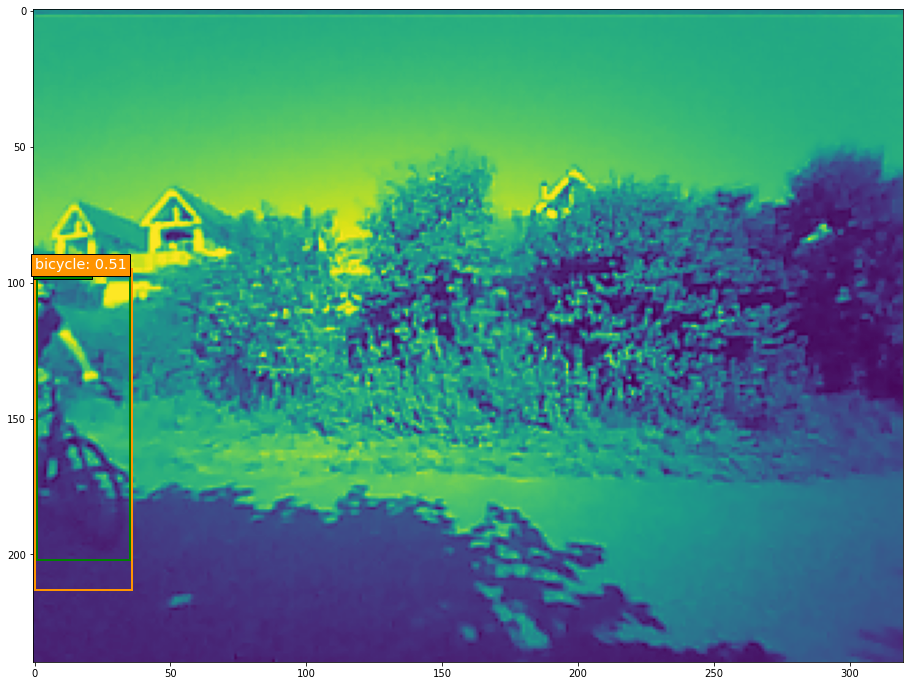

In [25]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [6]:
import cv2
sub = cv2.imread('./data_index/test/pic/192.168.43.116_1596958618865_sub.pgm',0)


In [8]:
print(sub)
print(sub.shape)

[[2 2 1 ... 4 3 4]
 [2 3 5 ... 2 1 2]
 [1 2 2 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 3]
 [1 1 1 ... 0 1 0]
 [2 2 2 ... 1 1 0]]
(240, 320)
